# Private 較高的版本

# Import packages we need and the data.

In [53]:
%matplotlib inline
import pandas as pd
import numpy as np
import scipy as sp
import time,datetime
import re
from bs4 import BeautifulSoup
import nltk
import xgboost as xgb
from nltk.corpus import stopwords
from nltk.stem.lancaster   import LancasterStemmer 
from nltk.stem.porter import PorterStemmer  
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn import feature_selection
from sklearn.model_selection  import GridSearchCV
from pandas_feature_union import PandasFeatureUnion

# xgb
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
from xgboost import plot_importance
from sklearn import metrics   #Additional scklearn functions

In [2]:
data = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')

# Feature engineering

* 文章複雜度 
* 文章長度倒數
* 文章圖片
* 文章影片數量
* 文章連結數量
* 文章標題長度
* 年分
* 月份
* 日期
* 星期幾
* 小時

In [37]:
class get_content_feature(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    def get_content_feature(self,text):

        # content soup
        soup =BeautifulSoup(text,'html.parser')
        content_html = soup.article.find('section',class_='article-content')
        
        ## descendants
        descend = soup.descendants
        descend = len(list(descend))
        
        ## 文章長度倒數
        inv_len = soup.get_text()
        inv_len = 1/np.log(len(inv_len))
        
        ## 文章圖片(文章中超過8張圖片就為1)
        img = 1 if len(BeautifulSoup(text, 'html.parser').find_all("img"))>8 else 0
        
        ## 影片數量
        video_num = soup.find_all("iframe")
        video_num = len(video_num)
        
        ## 文章連結數量
        href = len(soup.article.find_all("a"))
        
        ## title length
        title_length = len(soup.find(class_='title').get_text())
        
        ## year
        a = (BeautifulSoup(text, 'html.parser').time.get_text().split())
        if(len(a)==0):
            year = 2013
        else:
            year = np.int16(a[0][:4])
        
        ## month
        time_text = soup.time.get_text()
        if len(time_text) == 0:
            month = 6
        else:
            month = np.int(time_text[5:7])
            
        ## date
        if len(time_text) == 0 :
            date = 15
        else:
            date = np.int(time_text[8:10])
        
        ## day
        if len(time_text) == 0 :
            day = 'Wed'
        else:    
            day = soup.time.attrs['datetime'][0:3]
            
        ## hour
        if len(time_text) == 0 :
            hour = 12
        else:
            hour = np.int(time_text[11:13])

        
        
        return [inv_len,img,video_num,href,title_length,year,month,date,day,hour]
    
   
    def fit(self,text,y = None):
        return self
    
    def transform(self,text,y = None):
        df = [self.get_content_feature(i) for i in text]
        df = pd.DataFrame(df,columns=['inv_len','img','video_num','href','title_length',
                                        'year','month','date','day','hour'])
        return pd.get_dummies(df)


* 文章channel

In [14]:
class get_channel(BaseEstimator, TransformerMixin):
    """Takes in dataframe, extracts road name column, outputs average word length"""
    def get_channal(self,text):
        a = (BeautifulSoup((text), 'html.parser').article.attrs['data-channel'])
        return(a)
    def transform(self, text , y = None ):
        a = [self.get_channal(i) for i in text]
        a = pd.get_dummies(a)
        return (a)

    def fit(self, text, y=None):
        """Returns `self` unless something different happens in train and test"""
        return self
train_one_hot = get_channel().fit_transform(data['Page content'])
test_one_hot = get_channel().fit_transform(data_test['Page content'])
common_train, common_test  = train_one_hot.align(test_one_hot, join='inner', axis=1) 

class get_onehot(BaseEstimator, TransformerMixin):
    """Takes in dataframe, extracts road name column, outputs average word length"""
    def __init__(self):
        pass
    def transform(self, text , y = None ):
        b = get_channel().fit_transform(text)
        final_train, final_test  = b.align(common_train, join='inner', axis=1) 
        a = pd.DataFrame(final_train)
        return a

    def fit(self, text, y=None):
        """Returns `self` unless something different happens in train and test"""
        return self


* 時間與channel交乘項: 將月份分成季節來做避免overfitting。

In [22]:
'''
定義year dummy
定義month dummy
'''

class get_year_dummy(BaseEstimator, TransformerMixin):
    """Takes in dataframe, extracts road name column, outputs average word length"""
    def __init__(self):
        pass
    def get_year_dummy(self,text):
        a = (BeautifulSoup(text, 'html.parser').time.get_text().split())
        if(len(a)==0):
            return '2013'
        if a[0][:4] == '2015':
            return '2013'
        return a[0][:4]
    def transform(self, text , y = None ):
        return pd.get_dummies([self.get_year_dummy(i) for i in text])

    def fit(self, text, y=None):
        """Returns `self` unless something different happens in train and test"""
        return self
    

class  get_month_dummy(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def get_month_dummy(self,text):
        soup = BeautifulSoup(text)
        time_text = soup.time.get_text()
        if len(time_text) == 0 :
            return "06"
            
        month = time_text[5:7]
        return month
        
    def transform(self,text, y = None):
        return pd.get_dummies([self.get_month_dummy(i) for i in text])
    
    def fit(self, text, y=None):
        return self


'''
得到交乘項
年月 * channel
'''

class  get_interaction_term(BaseEstimator, TransformerMixin):
    def __init__(self,season = False ,imp = None):
        self.season = season
        self.imp = imp
        
    def get_interaction_term(self,text):
        
        year_df = get_year_dummy().fit_transform(text) # 年
        
        if self.season == False: # 是否分季
            month_df = get_month_dummy().fit_transform(text) # 月
        else:
            month_df = get_month_dummy().fit_transform(text)
            temp = []
            for i,j in zip(['spring','summer','fall','winter'],[['01','02','03'],['04','05','06'],['07','08','09'],['10','11','12']]):
                df = pd.DataFrame(month_df[j].sum(axis=1),columns=[i])
                temp.append(df)
            month_df = pd.concat(temp,axis=1)
            
        
        
        if self.imp == None:
            channel_df = get_onehot().fit_transform(text) # channel dummy
        else:
            channel_df = get_onehot().fit_transform(text)[self.imp]
            
            

        
        df_list = [] # 存df


        # 得到年月矩陣(elementwise product)

        
        for j in year_df.columns:
            temp = []
            col_name = [] # 存col names
            for i in month_df.columns:
                temp.append(pd.DataFrame(year_df[j]))
                col_name.append(str(j) + '_' + str(i))
            temp = pd.concat(temp,axis = 1)
            date_df = pd.DataFrame(temp.values * month_df.values ,columns=col_name)
            df_list.append(date_df)

        time_df = pd.concat(df_list,axis=1)
        

        # 年月矩陣*channel(elementwise product)

        
        df_list = []
        for j in channel_df.columns:
            temp = []
            for i in range(time_df.shape[1]):
                temp.append(pd.DataFrame(channel_df[j]))

            col_name = [j + '_' + k for k in time_df.columns]
            temp = pd.concat(temp,axis = 1)
            temp = pd.DataFrame(temp.values * time_df.values,columns=col_name)
            df_list.append(temp)
        
        self.interaction_df = pd.concat(df_list,axis=1)
        self.channel_df = channel_df
        return self
        
    def transform(self,text, y = None):
        self.get_interaction_term(text)
        return pd.concat([self.interaction_df,self.channel_df],axis=1)
    
    def fit(self, text, y = None):
        return self


In [42]:
feats = PandasFeatureUnion([
    ('content feature',get_content_feature()),
    ('year_month_channel_interaction',get_interaction_term(season = True))
    ])

Preprocess_pipe = Pipeline([('vect', feats)])

* Get feature DataFrame

In [43]:
X_feature = Preprocess_pipe.fit_transform(data['Page content'])
X_test_feature = Preprocess_pipe.fit_transform(data_test['Page content'])

In [48]:
(X_feature.columns == X_test_feature.columns).all() # 相同

True

# Start training

In [44]:
'''
這一步是為了以後方便我們添加新的變數
'''

train = X_feature
test = X_test_feature
predictors = [x for x in train.columns]

In [49]:
# 預覽
train.head()

inv_len  img  video_num  href  title_length  year  month  date  hour  \
0  0.121424    0          0    14            60  2013      6    19    15   
1  0.130946    0          0     8            74  2013      3    28    17   
2  0.112948    0         25     4            68  2014      5     7    19   
3  0.132066    0         21     7            43  2013     10    11     2   
4  0.109086    1          1     9            61  2014      4    17     3   

   day_Fri  ...  pics  small-business  social-media  socmed  sports  startups  \
0        0  ...     0               0             0       0       0         0   
1        0  ...     0               0             0       0       0         0   
2        0  ...     0               0             0       0       0         0   
3        1  ...     0               0             0       0       0         0   
4        0  ...     0               0             0       0       0         0   

   tech  us  watercooler  world  
0     0   0            0      1  
1     1   0            0      0  
2     0   0            0      0  
3     0   0            1      0  
4     0   0            0      0  

[5 rows x 277 columns]

* Define a training function (Use XGBoost model)

##### XGBoost

XGBoost(eXtrme Gradient Boosting)是Gradient boosting algorithm(GBM)的進階版本。XGBoost加入Regularized term減少overfitting來提升準確度，並改進了收斂速度。下列為XBGboost之優點。

1. Regularization:

標準的GBM並無regularization，xgb加入了Regularization因此可以較好避免overfitting。

2. Parallel Processing:

XGBBOOST可以實行平行運算計算速度可以提升很多。

3. High Flexibility

可以自行定義custom optimization objectives與evaluation criteria。

4. Built-in Cross-Validation

XGBOOST套件提供內建的Cross-validation，可以方便我們調整參數。

5. Importance

與許多方法相同，XGBoost也有挑選重要變數的功能。

基於以上優點我們選擇使用XGBOOST MODEL。
詳細內容可以參考此篇[論文](https://arxiv.org/abs/1603.02754)、[python套件](https://xgboost.readthedocs.io/en/latest/python/python_intro.html)或xgb附件。

In [51]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors], label=target.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds,verbose_eval = 20)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], target,eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(target.values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(target, dtrain_predprob))
                    
    plot_importance(alg,max_num_features=20)

### Tuning (5-fold cross validation)

* Inital step(setseed = 27)

給定一組起始參數並且設定learning rate = 0.1，並選擇最佳的n_estimator(iteration)。
在XGBoost中n_estimator是最重要的一個參數。

* Step1: Tune max_depth and min_child_weight.

我們首先對它們進行調整，因為它們將對模型結果產生最大的影響。 

* Step2: Tune gamma

調整gamma ， Regularization term。

* Step 3: Tune subsample and colsample_bytree

這個調整變數可以增加model穩健性。

* Step 4: Tuning Regularization Parameters

Reduce overfitting.

* Step 5: Reducing Learning Rate

減少Learning Rate，並且選出最佳的n_estimator。

In [65]:
target = data['Popularity']
for i in np.where(target == -1):
    target[i] = 0

# 先給定一組起始參數，並稍作調整。

xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=5000,
 max_depth=3,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=0.1,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

modelfit(xgb1,train,predictors)

C:\Users\stat-pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


[0]	train-auc:0.562269+0.00277667	test-auc:0.556129+0.0125611
[20]	train-auc:0.597435+0.00199109	test-auc:0.584523+0.0124599
[40]	train-auc:0.611487+0.00143756	test-auc:0.588133+0.0129992
[60]	train-auc:0.620517+0.00186408	test-auc:0.590732+0.0139095
[80]	train-auc:0.627888+0.00187471	test-auc:0.591679+0.0147474
[100]	train-auc:0.634321+0.00168801	test-auc:0.592473+0.0137412
[120]	train-auc:0.639677+0.00143985	test-auc:0.591637+0.0133486
[140]	train-auc:0.644893+0.00166103	test-auc:0.592107+0.0121664

Model Report
Accuracy : 0.5895
AUC Score (Train): 0.628871


* Step1 (tuning max_depth,min_child_weight)

In [66]:
param_test1 = {
 'max_depth':range(1,5,1),
 'min_child_weight':range(1,4,2)
}


gsearch1 = GridSearchCV(estimator = xgb1
                        ,param_grid = param_test1
                        , scoring='roc_auc'
                        ,n_jobs=4
                        ,iid=False
                        ,cv=5)

model1 = gsearch1.fit(train,target)

In [67]:
print(model1.best_params_)
print(model1.best_score_) # best score step1

{'max_depth': 4, 'min_child_weight': 1}
0.5942936154480012


* Step2 (tuning gamma)

In [68]:
param_test2 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier(**model1.best_estimator_.get_params()),
                        param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

model2 = gsearch2.fit(train,target)

In [69]:
print(model2.best_params_)
print(model2.best_score_) # best score step2

{'gamma': 0.1}
0.5948009348583196


* Step 3 (Tune subsample and colsample_bytree)

In [70]:
param_test3 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

# gamma
gsearch3 = GridSearchCV(estimator = XGBClassifier(**model2.best_estimator_.get_params()),
                        param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

model3 = gsearch3.fit(train,target)

In [71]:
print(model3.best_params_)
print(model3.best_score_) # best score step3

{'colsample_bytree': 0.8, 'subsample': 0.9}
0.5954153450686419


* Step 4 (Tuning Regularization Parameters)

In [72]:
param_test4 = {
 'reg_alpha':[0,1e-5, 1e-2, 0.1, 1, 100]
}

# colsample_bytree,subsample
gsearch4 = GridSearchCV(estimator = XGBClassifier(**model3.best_estimator_.get_params()), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

model4 = gsearch4.fit(train,target)

In [73]:
print(model4.best_params_)
print(model4.best_score_) # best score step4

{'reg_alpha': 1}
0.5968833164774013


* Step 5 (Reducing Learning Rate)

[0]	train-auc:0.570905+0.00395345	test-auc:0.557616+0.012136
[20]	train-auc:0.597512+0.00256434	test-auc:0.586095+0.0121333
[40]	train-auc:0.598779+0.00217716	test-auc:0.586394+0.0126523
[60]	train-auc:0.600076+0.00244454	test-auc:0.587198+0.0121455
[80]	train-auc:0.601242+0.00263476	test-auc:0.587643+0.0121924
[100]	train-auc:0.603228+0.0025385	test-auc:0.588407+0.0121796
[120]	train-auc:0.605574+0.00244064	test-auc:0.588959+0.0124367
[140]	train-auc:0.60798+0.00232221	test-auc:0.589538+0.0123249
[160]	train-auc:0.610054+0.00233941	test-auc:0.590044+0.0127168
[180]	train-auc:0.612009+0.00198579	test-auc:0.590676+0.0127618
[200]	train-auc:0.613895+0.00173627	test-auc:0.591097+0.0127308
[220]	train-auc:0.615823+0.00161781	test-auc:0.591348+0.0125684
[240]	train-auc:0.617682+0.00173492	test-auc:0.591845+0.0125917
[260]	train-auc:0.619398+0.00164438	test-auc:0.592096+0.0126331
[280]	train-auc:0.621009+0.00178723	test-auc:0.592259+0.0126041
[300]	train-auc:0.622644+0.00176641	test-auc:0.59

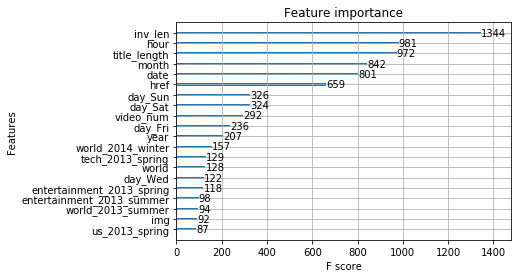

In [74]:
# Reduce the learning rate and research best n-estimators

final_param = model4.best_estimator_.get_params()
final_param["learning_rate"] = 0.01
final_param['n_estimators'] = 5000
final_param

xgb1 = XGBClassifier(**final_param)

modelfit(xgb1,train,predictors)

Model中比較重要的變數多與文章的長度、標題長度與文章時間資訊會是比較重要的資訊。我們猜測文章越長者，熱門程度越低。影片數量越多受歡迎程度也可能越高。並且文章在周末會是比較熱門的文章。

# 輸出

In [75]:
y_pred = xgb1.predict_proba(test)
y_pred_output=pd.DataFrame({"Id" : data_test['Id'],"Popularity": y_pred[:,1]
                })
y_pred_output.to_csv('sample_submission.csv',sep=",",index=False)